# Putting it all together: a case study
Every year for the past 40-plus years, Peter and Rosemary Grant have gone to the Galápagos island of Daphne Major and collected data on Darwin's finches. Using your skills in statistical inference, you will spend this chapter with their data, and witness first hand, through data, evolution in action. It's an exhilarating way to end the course!

# 1. Finch beaks and the need for statistics
## 1.1 EDA of beak depths of Darwin's finches
For your first foray into the Darwin finch data, you will study how the beak depth (the distance, top to bottom, of a closed beak) of the finch species _Geospiza scandens_ has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, _Geospiza fortis_. These effects can lead to changes in the species over time.

In the next few problems, you will look at the beak depth of _G. scandens_ on Daphne Major in 1975 and in 2012. To start with, let's plot all of the beak depth measurements in 1975 and 2012 in a bee swarm plot.

The data are stored in a pandas DataFrame called `df` with columns `'year'` and `'beak_depth'`. The units of beak depth are millimeters (mm).

### Instructions:
* Create the beeswarm plot.
* Label the axes.
* Show the plot.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
# Functions used in chapter

def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

def draw_bs_pairs_linreg(x, y, size=1):
    """ Perform pairs bootstrap for linear regression. """
    # Set up array of indices to sample from
    inds = np.arange(len(x))
    # Initialize samples
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    # Take samples
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps

def permutation_sample(data_1, data_2):
    permuted_data = np.random.permutation(np.concatenate((data_1, data_2)))
    return permuted_data[:len(data_1)], permuted_data[len(data_1):]

def draw_perm_reps(d1, d2, func, size=1):
    return np.array([func(*permutation_sample(d1, d2)) for i in range(size)])

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    return np.mean(data_1) - np.mean(data_2)

def pearson_r(data_1, data_2):
    return np.corrcoef(data_1, data_2)[0,1]

In [3]:
# Load datasets
df_75 = pd.read_csv('_datasets/finch_beaks_1975.csv')
df_12 = pd.read_csv('_datasets/finch_beaks_2012.csv')

# Create arrays of data values for scandens beak depth and beak length for years 1975 and 2012
bd_2012 = df_12.loc[df_12.species=='scandens', 'bdepth'].values
bd_1975 = df_75.loc[df_75.species=='scandens', 'Beak depth, mm'].values
bl_2012 = df_12.loc[df_12.species=='scandens', 'blength'].values
bl_1975 = df_75.loc[df_75.species=='scandens', 'Beak length, mm'].values

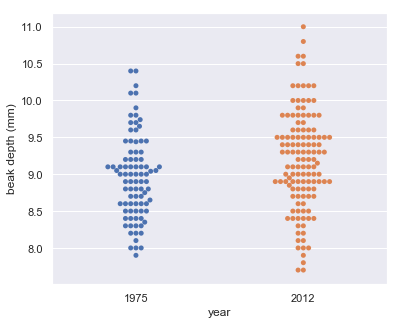

In [4]:
# Unify column headers 
df_75 = df_75.rename(columns={'Beak depth, mm': 'beak_depth'})
df_12 = df_12.rename(columns={'bdepth': 'beak_depth'})
# Add year column
df_75['year'] = [1975]*len(df_75)
df_12['year'] = [2012]*len(df_12)
# Define df combined on df_75 and df_12
df = df_75.loc[df_75.species=='scandens', 
               ['beak_depth', 'year']].append(df_12.loc[df_12.species=='scandens', ['beak_depth', 'year']], ignore_index=True)

# Specify plot size
plt.rcParams['figure.figsize'] = [6, 5]

# Create bee swarm plot
_ = sns.swarmplot(x='year', y='beak_depth', data=df)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
plt.show()

It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the mean of the 2012 data set might be slightly higher, and it might have a bigger variance.

## 1.2 ECDFs of beak depths
While bee swarm plots are useful, we found that ECDFs are often even better when doing EDA. Plot the ECDFs for the 1975 and 2012 beak depth measurements on the same plot.

For your convenience, the beak depths for the respective years has been stored in the NumPy arrays `bd_1975` and `bd_2012`.

### Instructions:
* Compute the ECDF for the 1975 and 2012 data.
* Plot the two ECDFs.
* Set a 2% margin and add axis labels and a legend to the plot.

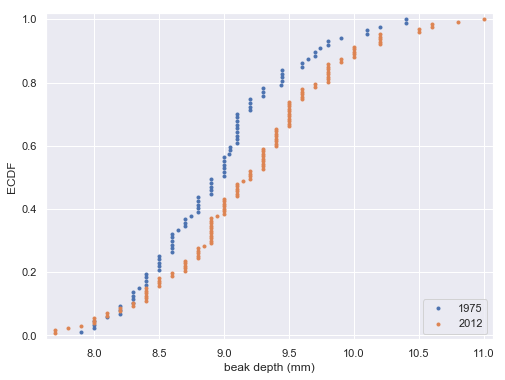

In [5]:
# Specify plot size
plt.rcParams['figure.figsize'] = [8, 6]

# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
_ = plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

The differences are much clearer in the ECDF. The mean is larger in the 2012 data, and the variance does appear larger as well.

## 1.3 Parameter estimates of beak depths
Estimate the _difference_ of the mean beak depth of the _G. scandens_ samples from 1975 and 2012 and report a 95% confidence interval.

Since in this exercise you will use the `draw_bs_reps()` function you wrote in chapter 2, it may be helpful to refer back to it.

### Instructions:
* Compute the difference of the sample means.
* Take 10,000 bootstrap replicates of the mean for the 1975 beak depths using your `draw_bs_reps()` function. Also get 10,000 bootstrap replicates of the mean for the 2012 beak depths.
* Subtract the 1975 replicates from the 2012 replicates to get bootstrap replicates of the difference of means.
* Use the replicates to compute the 95% confidence interval.

In [6]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.06047545 0.38938024] mm


## 1.4 Hypothesis test: Are beaks deeper in 2012?
Your plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of _G. scandens_ on Daphne Major have gotten deeper. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

Be careful! The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The hypothesis is that the means are equal. To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

### Instructions:
* Make a concatenated array of the 1975 and 2012 beak depths and compute and store its mean.
* Shift `bd_1975` and `bd_2012` such that their means are equal to the one you just computed for the combined data set.
* Take 10,000 bootstrap replicates of the mean each for the 1975 and 2012 beak depths.
* Subtract the 1975 replicates from the 2012 replicates to get bootstrap replicates of the difference.
* Compute and print the p-value. The observed difference in means you computed in the last exercise is still in your namespace as `mean_diff`.

In [7]:
np.random.seed(42)

# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0034


We get a p-value of 0.0034, which suggests that there is a statistically significant difference. But remember: it is very important to know how different they are! In the previous exercise, you got a difference of 0.2 mm between the means. You should combine this with the statistical significance. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.

# 2. Variation of beak shapes
## 2.1 EDA of beak length and depth
The beak length data are stored as `bl_1975` and `bl_2012`, again with units of millimeters (mm). You still have the beak depth data stored in `bd_1975` and `bd_2012`. Make scatter plots of beak depth (y-axis) versus beak length (x-axis) for the 1975 and 2012 specimens.

### Instructions:
* Make a scatter plot of the 1975 data. Use the `color='blue'` keyword argument. Also use an `alpha=0.5` keyword argument to have transparency in case data points overlap.
* Do the same for the 2012 data, but use the `color='red'` keyword argument.
* Add a legend and label the axes.

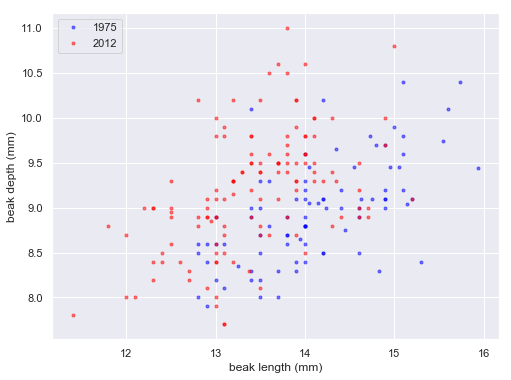

In [8]:
# Specify plot size
plt.rcParams['figure.figsize'] = [8, 6]

# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

In looking at the plot, we see that beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; they became shorter and deeper.

## 2.2 Linear regressions
Perform a linear regression for both the 1975 and 2012 data. Then, perform pairs bootstrap estimates for the regression parameters. Report 95% confidence intervals on the slope and intercept of the regression line.

You will use the `draw_bs_pairs_linreg()` function you wrote back in chapter 2.

As a reminder, its call signature is `draw_bs_pairs_linreg(x, y, size=1)`, and it returns `bs_slope_reps` and `bs_intercept_reps`.

### Instructions:
* Compute the slope and intercept for both the 1975 and 2012 data sets.
* Obtain 1000 pairs bootstrap samples for the linear regressions using your `draw_bs_pairs_linreg()` function.
* Compute 95% confidence intervals for the slopes and the intercepts.

In [9]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

# Print the results
print('1975: slope =    ', slope_1975, '\tconf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975, '\tconf int =', intercept_conf_int_1975)
print('2012: slope =    ', slope_2012, '\tconf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012, '\tconf int =', intercept_conf_int_2012)

1975: slope =     0.4652051691605937 	conf int = [0.33204478 0.59449384]
1975: intercept = 2.3908752365842254 	conf int = [0.58355792 4.31190024]
2012: slope =     0.4626303588353129 	conf int = [0.33186804 0.60236634]
2012: intercept = 2.9772474982360184 	conf int = [1.09485964 4.76711109]


It looks like they have the same slope, but different intercepts.

## 2.3 Displaying the linear regression results
Now, you will display your linear regression results on the scatter plot, the code for which is already pre-written for you from your previous exercise. To do this, take the first 100 bootstrap samples (stored in `bs_slope_reps_1975`, `bs_intercept_reps_1975`, `bs_slope_reps_2012`, and `bs_intercept_reps_2012`) and plot the lines with `alpha=0.2` and `linewidth=0.5` keyword arguments to `plt.plot()`.

### Instructions:
* Generate the x-values for the bootstrap lines using `np.array()`. They should consist of 10 mm and 17 mm.
* Write a `for` loop to plot 100 of the bootstrap lines for the 1975 and 2012 data sets. The lines for the 1975 data set should be `'blue'` and those for the 2012 data set should be `'red'`.

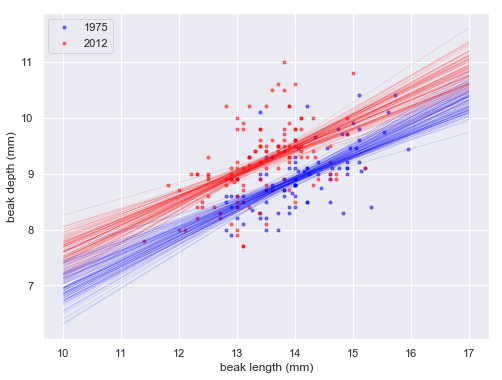

In [10]:
# Specify plot size
plt.rcParams['figure.figsize'] = [8, 6]

# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.', linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i], linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i], linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

## 2.4 Beak length to depth ratio
The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years. However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth. Let's make that comparison.

Remember, the data are stored in `bd_1975`, `bd_2012`, `bl_1975`, and `bl_2012`.

### Instructions:
* Make arrays of the beak length to depth ratio of each bird for 1975 and for 2012.
* Compute the mean of the length to depth ratio for 1975 and for 2012.
* Generate 10,000 bootstrap replicates each for the mean ratio for 1975 and 2012 using your `draw_bs_reps()` function.
* Get a __99%__ bootstrap confidence interval for the length to depth ratio for 1975 and 2012.
* Print the results.

In [11]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975/bd_1975
ratio_2012 = bl_2012/bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5,99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5,99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975, '\tconf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012, '\tconf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 	conf int = [1.55684007 1.60131071]
2012: mean ratio = 1.4658342276847767 	conf int = [1.44411705 1.48750423]


## 2.5 How different is the ratio?
In the previous exercise, you computed the mean beak length to depth ratio with 99% confidence intervals for 1975 and for 2012. The results of that calculation are shown graphically in the plot accompanying this problem. In addition to these results, what would you say about the ratio of beak length to depth?

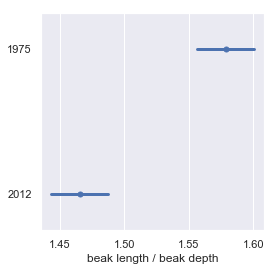

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 1])
ax.set_yticklabels(['2012', '1975'])
ax.grid(False, axis='y')
ax.plot([1.5788823771858533], [1], '.', markersize=10, color=sns.color_palette()[0])
ax.plot([1.55668803, 1.60073509], [1, 1], '-', linewidth=3, color=sns.color_palette()[0])
ax.plot([1.4658342276847767], [0], '.', markersize=10, color=sns.color_palette()[0])
ax.plot([1.44363932, 1.48729149], [0, 0], '-', linewidth=3, color=sns.color_palette()[0])
ax.set_xlabel('beak length / beak depth')
# print(plt.rcParams['figure.figsize'])
plt.show()

#### Answer:
* The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.

# 3. Calculation of heritability
## 3.1 EDA of heritability
The array `bd_parent_scandens` contains the average beak depth (in mm) of two parents of the species `G. scandens`. The array `bd_offspring_scandens` contains the average beak depth of the offspring of the respective parents. The arrays `bd_parent_fortis` and `bd_offspring_fortis` contain the same information about measurements from _G. fortis_ birds.

Make a scatter plot of the average offspring beak depth (y-axis) versus average parental beak depth (x-axis) for both species. Use the `alpha=0.5` keyword argument to help you see overlapping points.

### Instructions:
* Generate scatter plots for both species. Display the data for _G. fortis_ in blue and _G. scandens_ in red.
* Set the axis labels, make a legend, and show the plot.

In [13]:
# Load datasets
df_fortis = pd.read_csv('_datasets/fortis_beak_depth_heredity.csv')
df_scandens = pd.read_csv('_datasets/scandens_beak_depth_heredity.csv')

# Create arrays of data values for G. scandens and G. fortis for parents and offsprings
bd_parent_fortis = ((df_fortis['Male BD'] + df_fortis['Female BD']) / 2).values
bd_offspring_fortis = df_fortis['Mid-offspr'].values
bd_parent_scandens = df_scandens.mid_parent.values
bd_offspring_scandens = df_scandens.mid_offspring.values\

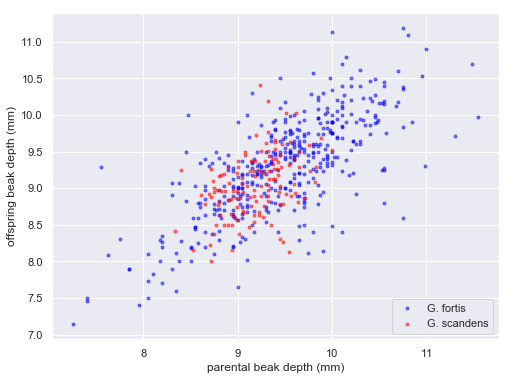

In [14]:
# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis, marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens, marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()

It appears as though there is a stronger correlation in `G. fortis` than in `G. scandens`. This suggests that beak depth is more strongly inherited in `G. fortis`.

## 3.2 Correlation of offspring and parental data
In an effort to quantify the correlation between offspring and parent beak depths, we would like to compute statistics, such as the Pearson correlation coefficient, between parents and offspring. To get confidence intervals on this, we need to do a pairs bootstrap.

You have already written a function `draw_bs_pairs_linreg(x, y, size=1)` to do pairs bootstrap to get estimates for parameters derived from linear regression. Your task in this exercise is to make a new function with call signature `draw_bs_pairs(x, y, func, size=1)` that performs pairs bootstrap and computes a single statistic on pairs samples defined. The statistic of interested in computed by calling `func(bs_x, bs_y)`. In the next exercise, you will use `pearson_r` for func.

### Instructions:
* Set up an array of indices to sample from. (Remember, when doing pairs bootstrap, we randomly choose indices and use those to get the pairs.)
* Initialize the array of bootstrap replicates. This should be a one-dimensional array of length `size`.
* Write a `for` loop to draw the samples.
* Randomly choose induces from the array of indices you previously set up.
* Extract `x` values and `y` values from the input array using the indices you just chose to generate a bootstrap sample.
* Use `func` to compute the statistic of interest from the bootstrap samples of `x` and `y` and store it in your array of bootstrap replicates.
* Return the array of bootstrap replicates.

In [15]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

## 3.3 Pearson correlation of offspring and parental data
The Pearson correlation coefficient seems like a useful measure of how strongly the beak depth of parents are inherited by their offspring. Compute the Pearson correlation coefficient between parental and offspring beak depths for _G. scandens_. Do the same for _G. fortis_. Then, use the function you wrote in the last exercise to compute a 95% confidence interval using pairs bootstrap.

Remember, the data are stored in `bd_parent_scandens`, `bd_offspring_scandens`, `bd_parent_fortis`, and `bd_offspring_fortis`.

### Instructions:
* Use the `pearson_r()` function you wrote in the prequel to this course to compute the Pearson correlation coefficient for _G. scandens_ and _G. fortis_.
* Acquire 1000 pairs bootstrap replicates of the Pearson correlation coefficient using the `draw_bs_pairs()` function you wrote in the previous exercise for _G. scandens_ and _G. fortis_.
* Compute the 95% confidence interval for both using your bootstrap replicates.

In [16]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, pearson_r, 1000)
bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, pearson_r, 1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:\tPerson correlation coef:', r_scandens, '\t95% conf int =', conf_int_scandens)
print('G. fortis:  \tPerson correlation coef:', r_fortis, '\t95% conf int =', conf_int_fortis)

G. scandens:	Person correlation coef: 0.41170636294012586 	95% conf int = [0.27287511 0.54092141]
G. fortis:  	Person correlation coef: 0.7283412395518484 	95% conf int = [0.66804693 0.78088891]


It is clear from the confidence intervals that beak depth of the offspring of `G. fortis` parents is more strongly correlated with their offspring than their `G. scandens` counterparts.

## 3.4 Measuring heritability
Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the _variance of the parents alone_. In this exercise, you will estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

This exercise highlights a very important point. Statistical inference (and data analysis in general) is not a plug-n-chug enterprise. You need to think carefully about the questions you are seeking to answer with your data and analyze them appropriately. If you are interested in how heritable traits are, the quantity we defined as the heritability is more apt than the off-the-shelf statistic, the Pearson correlation coefficient.

### Instructions:
* Write a function `heritability(parents, offspring)` that computes heritability defined as the ratio of the covariance of the trait in parents and offspring divided by the variance of the trait in the parents. _Hint_: Remind yourself of the `np.cov()` function we covered in the prequel to this course.
* Use this function to compute the heritability for _G. scandens_ and _G. fortis_.
* Acquire 1000 bootstrap replicates of the heritability using pairs bootstrap for _G. scandens_ and _G. fortis_.
* Compute the 95% confidence interval for both using your bootstrap replicates.
* Print the results.

In [17]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:\t heritability:', heritability_scandens, '\t95% conf int', conf_int_scandens)
print('G. fortis:\t heritability:', heritability_fortis, '\t95% conf int', conf_int_fortis)

G. scandens:	 heritability: 0.5485340868685982 	95% conf int [0.3495785  0.75068325]
G. fortis:	 heritability: 0.7229051911438156 	95% conf int [0.64896056 0.79679239]


Here again, we see that _G. fortis_ has stronger heritability than _G. scandens_. This suggests that the traits of _G. fortis_ may be strongly incorporated into _G. scandens_ by introgressive hybridization.

## 3.5 Is beak depth heritable at all in G. scandens?
The heritability of beak depth in _G. scandens_ seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. You will test that hypothesis here. To do this, you will do a pairs permutation test.

### Instructions:
* Initialize your array of replicates of heritability. We will take 10,000 pairs permutation replicates.
* Write a `for` loop to generate your replicates.
    * Permute the `bd_parent_scandens` array using `np.random.permutation()`.
    * Compute the heritability between the permuted array and the `bd_offspring_scandens` array using the `heritability()` function you wrote in the last exercise. Store the result in the replicates array.
* Compute the p-value as the number of replicates that are greater than the observed `heritability_scandens` you computed in the last exercise.

In [18]:
np.random.seed(42)

# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)


# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)

p-val = 0.0


You get a p-value of zero, which means that none of the 10,000 permutation pairs replicates you drew had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in _G. scandens_, just not as much as in _G. fortis_. If you like, you can plot a histogram of the heritability replicates to get a feel for how extreme of a value of heritability you might expect by chance.

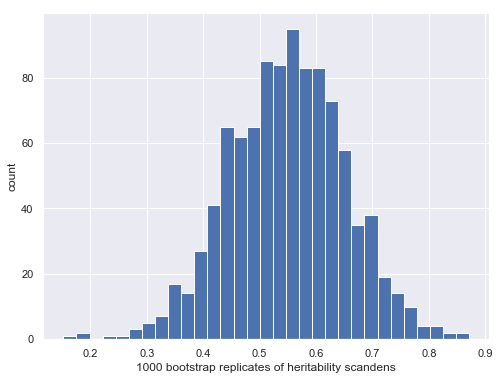

In [19]:
n_bins = int(np.sqrt(len(replicates_scandens)))
plt.hist(replicates_scandens, bins=n_bins)
# Label axes
_ = plt.xlabel('1000 bootstrap replicates of heritability scandens')
_ = plt.ylabel('count')
plt.show()

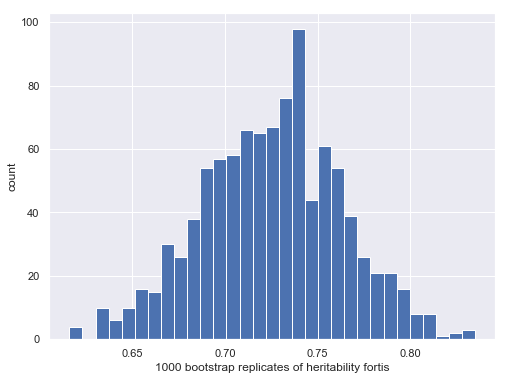

In [20]:
n_bins = int(np.sqrt(len(replicates_fortis)))
plt.hist(replicates_fortis, bins=n_bins)
# Label axes
_ = plt.xlabel('1000 bootstrap replicates of heritability fortis')
_ = plt.ylabel('count')
plt.show()

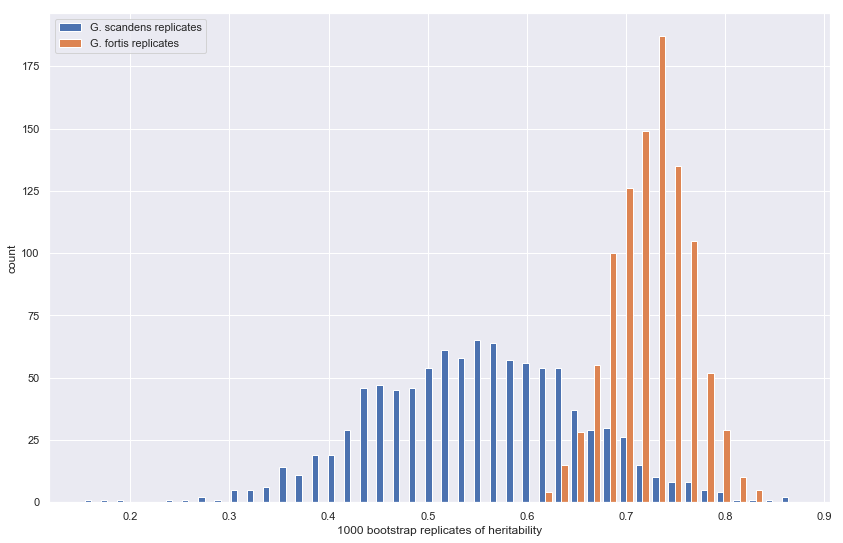

In [21]:
# Specify plot size
plt.rcParams['figure.figsize'] = [14, 9]

n_bins = int(np.sqrt(len(replicates_fortis)+len(replicates_scandens)))

plt.hist([replicates_scandens, replicates_fortis], bins=n_bins)
# Label axes
_ = plt.xlabel('1000 bootstrap replicates of heritability')
_ = plt.ylabel('count')
_ = plt.legend(('G. scandens replicates', 'G. fortis replicates'), loc='upper left')
plt.show()